The drift difussion model (DDM) is a type of sequential sampling model (SSM) which, until now, has been uniquely applied in impulsive / non-deliberated two-choice decisions. These SSM models, and thus the DDM, assume that decisions are made by accumulating information until a threshold is reached. In order to model this accumulation of knowledge, DDM uses a random walk in two dimensions, starting at point z and finishing when it reaches a decision threshold (a or 0). 

The starting point z can be understood as an initial bias, which can be due to previous experiences or intuitive notions. On the other hand, the boundaries represent the minimum accumulated knowledge needed to make a decision, so harder decisions will have wider boundaries than simple choices.

The speed by which the information is accumulated is defined as $v$ (drift rate) and it is a constant value throughout the experiment. In past papers, the drift rate $v$ has been defined positive when the accumulation of information led to the right decision (and negative in the opposite case) but, as decisions in cooperation-defection experiments are not right or wrong, $v$ will be defined as positive when the accumulation of knowledge leads to a cooperative choice (and negative on the contrary). 

Apart from the drift rate, there is a source of stochastic noise in the decision process. Using the same parameters v and z, this noise will lead to different final decisions and different final times. Thevariability in decision times will produce the characteristic distribution of RT (reaction time) and the two possible final decisions will bring errors and the corresponding error RT distribution.

One last parameter $t_0$?

The equation which represents the probability distribution:
$$P(t| v,a,z)=\frac{\pi}{a^2}\exp{(-vza-\frac{v^2 t}{2})} × \sum_{k=1}^\infty k \exp{(-\frac{k^2\pi ^2 t}{2a^2})}\sin{(k\pi z)}$$

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5112760/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4928591/
http://star.psy.ohio-state.edu/wp/?page_id=169

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
import hddm
print(hddm.__version__)

0.6.0


In [3]:
def parse_files(files_to_parse):
    o=open("output_data.dat","w")
    for index,i in enumerate(files_to_parse):
        if index==0:
            for line in open("Esther/history_"+i+".dat"):
                o.write(line.replace(" ",",").replace("usuario",i+"_usuario")) 
        else:
            f=open("Esther/history_"+i+".dat")
            f.readline()
            for line in f:
                o.write(line.replace(" ",",").replace("usuario",i+"_usuario") ) 
    o.close()
    return 

files_to_parse=["s3m7","s4m8","s5m20","s6m22","s7m22","s8n3","s9n3","s10n5","s11n9","s13n12","s12n11"]
parse_files(files_to_parse)


IOError: [Errno 2] No such file or directory: 'Esther/history_s3m7.dat'

In [87]:
data = hddm.load_csv('output_data.dat')
data.head()

,round,player,action_player,opponent,action_opponent,payoff,time_php,time_js,who_played
0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,4480.199814,4452,user
1,1,s3m7_usuario18,C,['s3m7_usuario9'],D,0,9472.300053,9443,user
2,1,s3m7_usuario7,C,['s3m7_usuario10'],C,3,2238.199949,2213,user
3,1,s3m7_usuario10,C,['s3m7_usuario7'],C,3,8133.699894,8101,user
4,1,s3m7_usuario13,C,['s3m7_usuario5'],C,3,5098.500013,5043,user


In [88]:
#only user (not autom) and delete "who played"
data=data[data["who_played"]=="user"]
del data["who_played"]

#rename for rt and response columns
data.rename(columns={'time_js':'rt', "action_player":"response"}, inplace=True) 

#make rt floats
data['rt'] = data.rt.astype(int)

#coop is 1, defl is 0
data.loc[data['response'] == "C", "response"] = 1.0
data.loc[data['response'] == "D", "response"] = 0.0
data.loc[data['action_opponent'] == "C", "action_opponent"] = 1.0
data.loc[data['action_opponent'] == "D", "action_opponent"] = 0.0

#add strategy
data["strategy"]=[str(data["response"][i])+str(data["action_opponent"][i]) for i in range(len(data))]

#rt in seconds
data["rt"]=data["rt"]/1000

#rt which are defect become neg
data = hddm.utils.flip_errors(data)

data2=data.copy()
data2.rename(columns={"player":"subj_idx"},inplace=True)

data=data[(data["rt"]<=20) & (data["rt"]>=-20)]
data.head()


,round,player,response,opponent,action_opponent,payoff,time_php,rt,strategy
0,1,s3m7_usuario9,0,['s3m7_usuario18'],1,4,4480.199814,-4.452,01
1,1,s3m7_usuario18,1,['s3m7_usuario9'],0,0,9472.300053,9.443,10
2,1,s3m7_usuario7,1,['s3m7_usuario10'],1,3,2238.199949,2.213,11
3,1,s3m7_usuario10,1,['s3m7_usuario7'],1,3,8133.699894,8.101,11
4,1,s3m7_usuario13,1,['s3m7_usuario5'],1,3,5098.500013,5.043,11


In [89]:
data2.head() #data2 will be used to plot by player

,round,subj_idx,response,opponent,action_opponent,payoff,time_php,rt,strategy
0,1,s3m7_usuario9,0,['s3m7_usuario18'],1,4,4480.199814,-4.452,01
1,1,s3m7_usuario18,1,['s3m7_usuario9'],0,0,9472.300053,9.443,10
2,1,s3m7_usuario7,1,['s3m7_usuario10'],1,3,2238.199949,2.213,11
3,1,s3m7_usuario10,1,['s3m7_usuario7'],1,3,8133.699894,8.101,11
4,1,s3m7_usuario13,1,['s3m7_usuario5'],1,3,5098.500013,5.043,11


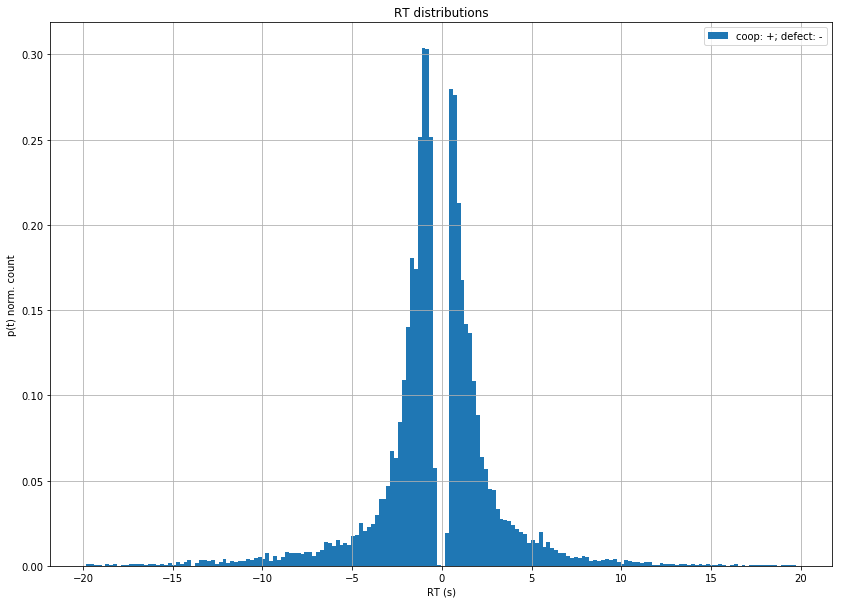

In [116]:
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions')
data.rt.hist(bins="auto",  ax=ax, density=True, histtype="stepfilled")
plt.legend(["coop: +; defect: -"])
plt.savefig('jelena_rt.png')

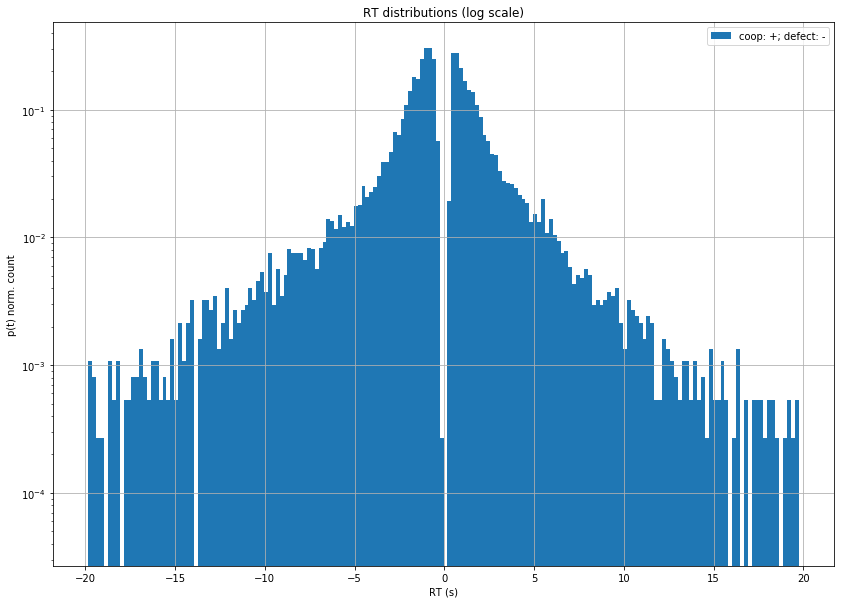

In [117]:
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions (log scale)')
data.rt.hist(log=True,bins="auto",  ax=ax, density=True, histtype="stepfilled")
plt.legend(["coop: +; defect: -"])
plt.savefig('jelena_rt_logscale.png')

In [34]:
#basic model
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
m.sample(2000, burn=20)


-41694.17222063734
-41693.46897525756


C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 510.3 sec

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [35]:
#get statistics from a t and v
stats = m.gen_stats()
stats[stats.index.isin(['a', "t", 'v'])]

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,3.006,0.010209,2.98605,2.99907,3.00568,3.01306,3.02602,0.000327388
v,-0.0687681,0.00505432,-0.0783746,-0.0720518,-0.0688956,-0.0655312,-0.0584373,0.000107483
t,0.0656802,0.0048031,0.056113,0.0623949,0.0658058,0.0687653,0.0750042,0.000147726


Plotting a
Plotting v
Plotting t


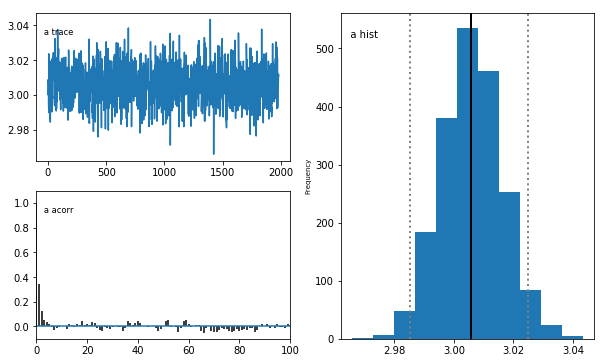

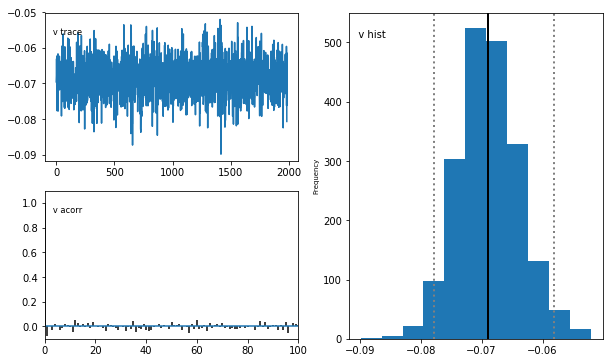

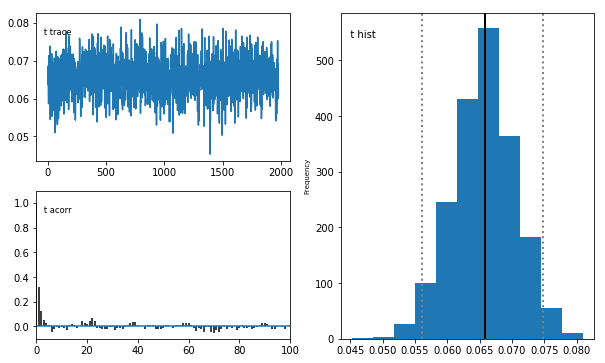

In [36]:
#check convergence
m.plot_posteriors()
#no drifts or large jumps in the trace (non stationary). The autocorrelation is also very low.



C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 983.7 sec

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


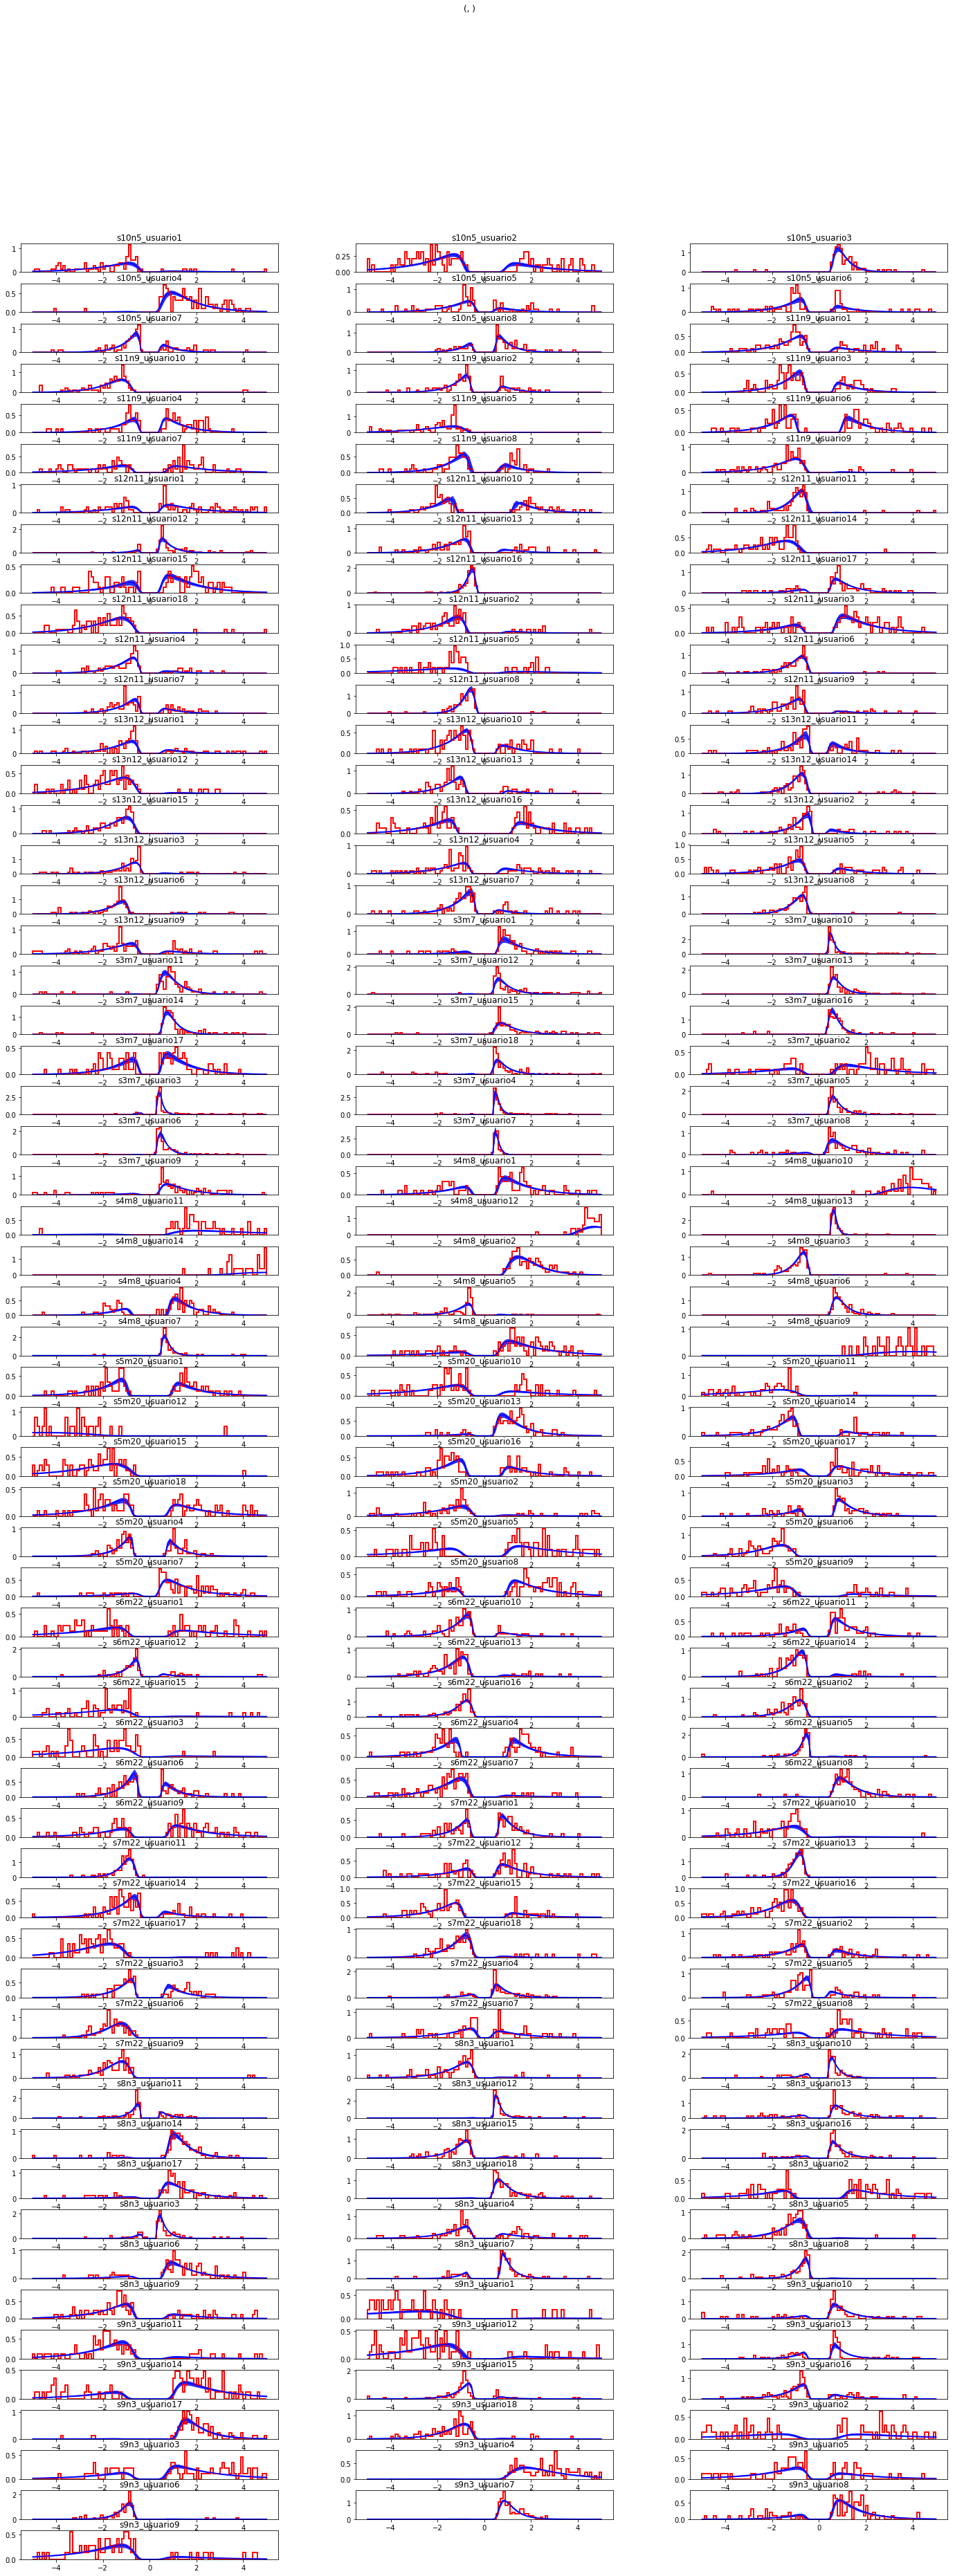

In [51]:
#basic model by players
m2 = hddm.HDDM(data2, p_outlier=.05)
# find a good starting point which helps with the convergence.
m2.find_starting_values()
m2.sample(2000, burn=20)
#by player
m2.plot_posterior_predictive(figsize=(24, 60))
#m2.gen_starts()

In [62]:
stats2 = m2.gen_stats()
print(stats2)

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                             mean        std       2.5q       25q       50q  \
a                         2.89608  0.0948254    2.72388   2.83006   2.89306   
a_std                     1.15604  0.0937253   0.992274   1.09034   1.14986   
a_subj.s10n5_usuario1     3.33817    0.20753    2.93927    3.1973   3.33516   
a_subj.s10n5_usuario2     3.01595   0.162932     2.7349   2.89832   3.00476   
a_subj.s10n5_usuario3     2.88227   0.474994     2.1524   2.52874   2.81774   
a_subj.s10n5_usuario4     3.59624   0.272071    3.10393   3.39887    3.5849   
a_subj.s10n5_usuario5     2.41834   0.191675    2.07409   2.28455   2.40296   
a_subj.s10n5_usuario6     2.18286   0.161872    1.87125   2.07246   2.18402   
a_subj.s10n5_usuario7     1.81053   0.105601    1.61013   1.73909   1.80933   
a_subj.s10n5_usuario8     1.71798  0.0929673    1.54508   1.65227   1.71548   
a_subj.s11n9_usuario1     2.43552   0.146491    2.17305   2.33618   2.42641   
a_subj.s11n9_usuario10    3.74169   0.440306    3.00

-31520.716251052196
-31520.635564316493


C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 2389.9 sec

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


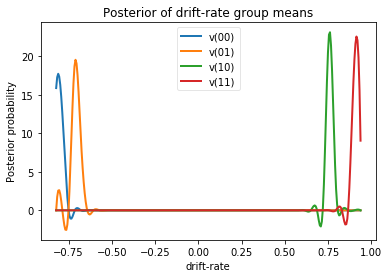

In [38]:
#distribution depending on strategy
m_stim = hddm.HDDM(data, depends_on={'v': 'strategy'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)

v_WW, v_LL, v_WL,v_LW = m_stim.nodes_db.node[['v(00)', 'v(01)', 'v(10)','v(11)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL, v_LW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('hddm_demo_fig_06.pdf')

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 504.6 sec

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


 [-----------------100%-----------------] 2000 of 2000 complete in 465.7 sec       mean         std      2.5q        25q        50q        75q      97.5q  \
a   2.39896   0.0108826   2.37768    2.39179     2.3989    2.40628    2.42156   
v -0.086966  0.00709016 -0.101044 -0.0917754 -0.0868743 -0.0822121 -0.0729009   
t  0.218244  0.00361806  0.211134    0.21581   0.218308   0.220655   0.225329   

        mc err  
a  0.000350633  
v  0.000151909  
t  0.000123473  


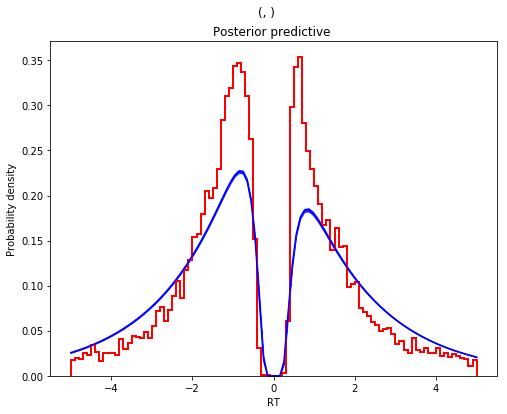

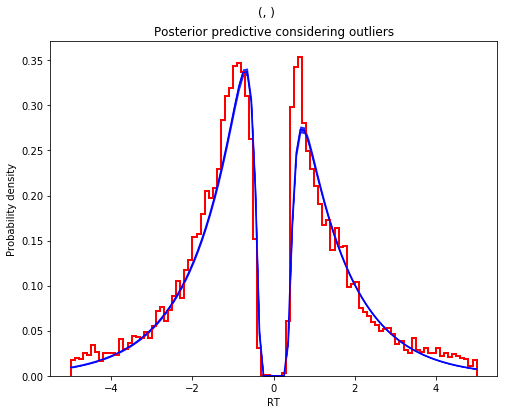

In [64]:
#comparing distributions: dealing with outliers 
#comaprison with outlayers to see which model fits better
m_no_outlier = hddm.HDDM(data)
m_no_outlier.sample(2000, burn=50)
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive ')
plt.xlabel('RT')
plt.ylabel('Probability density')
#plt.savefig('hddm_demo_fig_10.pdf')

m_outlier = hddm.HDDM(data, p_outlier=.05)
m_outlier.sample(2000, burn=20)
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive considering outliers')
plt.xlabel('RT')
plt.ylabel('Probability density')
stats3=m_outlier.gen_stats()
print(stats3)

In [ ]:
#by player

172


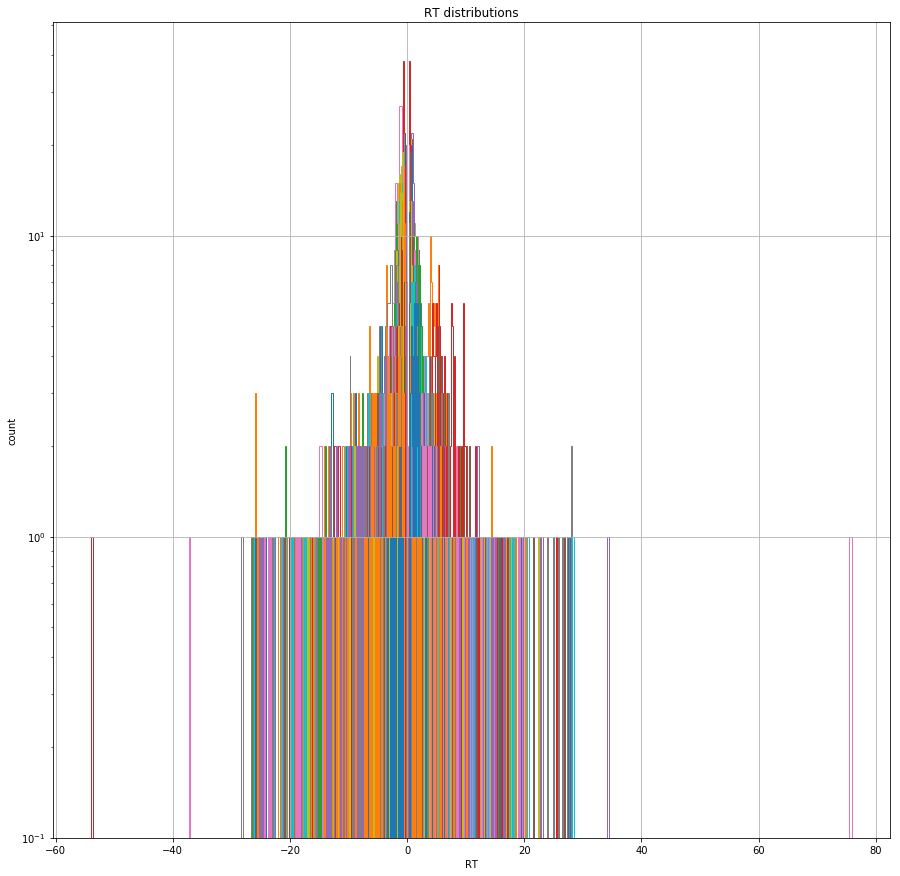

In [53]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby("player"):
    subj_data.rt.hist(log=True,bins=200,  ax=ax,histtype="step")
print(len(data.groupby("player")))
#plt.savefig('hddm_demo_fig_00.pdf')

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 479.1 sec

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


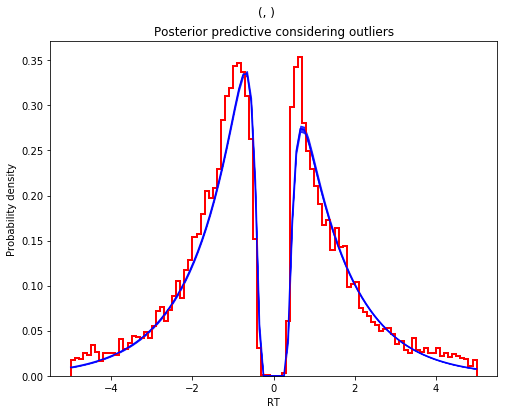

In [103]:
#if we want analisis by player change player by subj_idx

m_outlier = hddm.HDDM(data, p_outlier=.05)
m_outlier.sample(2000, burn=20)
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive considering outliers')
plt.xlabel('RT')
plt.ylabel('Probability density')
plt.savefig('jelena_rt_aprox.pdf')

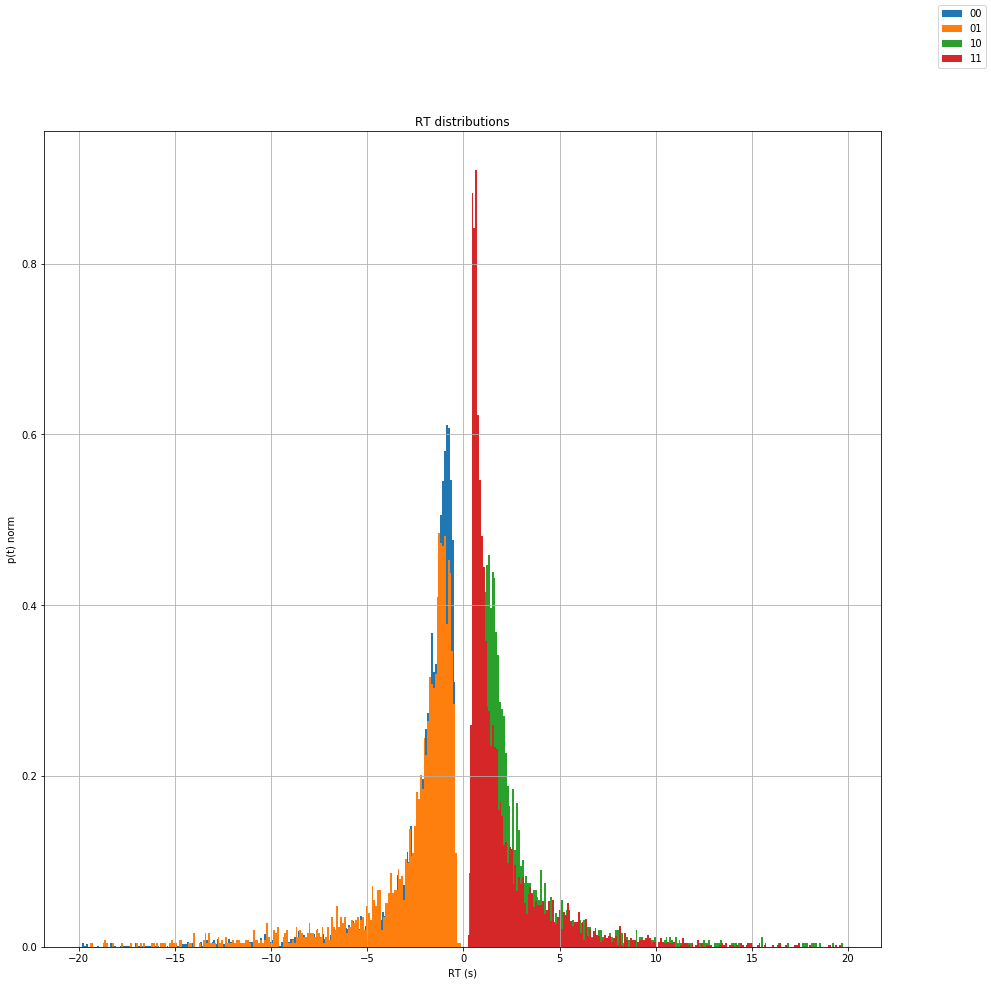

In [121]:
#by strategy
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm', title='RT distributions')
for i, subj_data in data.groupby("strategy"):
    subj_data.rt.hist(bins=200,  ax=ax, density=True)
fig.legend(["00","01","10","11"])
#plt.savefig('hddm_demo_fig_00.pdf')
#if player cooperates, oponent choice does not matter for decision time. ohter player choice only matters when we defect

In [ ]:
model = hddm.HDDM(data)

# Create model and start MCMC sampling
model.sample(200, burn=20)

# Print fitted parameters and other model statistics
model.print_stats()

# Plot posterior distributions and theoretical RT distributions
model.plot_posteriors()
model.plot_posterior_predictive()

In [ ]:
#posterior prediction?

## Dec Times Elias

In [98]:
dat = hddm.load_csv('crd_dataset_time_ns.csv')
del dat["time_elapsed_action"], dat["time_elapsed_pred"]
dat.rename(columns={"etimeactionnr":"rt"},inplace=True)
#0 and 4 extreme become 1, 2 becomes 0
dat["response"]=[1 if( dat["actions"][i]==0 or dat["actions"][i]==4) else 0 for i in range(len(dat))]
#rt which are defect become neg
dat = hddm.utils.flip_errors(dat)
dat["rt"]=dat["rt"]/10e9
two=dat[dat["actions"]==2]
zero=dat[dat["actions"]==0]
four=dat[dat["actions"]==4]
dat.head()

,index,actions,age,degree,group,knows_game,knows_gt,level_studies,player,predictions,...,time_end_action,time_end_pred,time_start_action,time_start_pred,treatment,gap_threshold,round_donations,rt,etimeprednr,response
0,0,0,26,Computer Science,21,False,0.0,master,60,10.0,...,2017-11-22 07:36:25.118000000,2017-11-22 07:36:36.341000000,2017-11-22 07:36:08.645000000,2017-11-22 07:36:25.683000000,1,74,10,1.6473,10658000000,1
1,1,0,26,Computer Science,21,False,0.0,master,60,10.0,...,2017-11-22 07:38:10.285000000,2017-11-22 07:38:27.301000000,2017-11-22 07:37:44.650000000,2017-11-22 07:38:20.974000000,1,56,6,2.5635,6327000000,1
2,2,4,26,Computer Science,21,False,0.0,master,60,14.0,...,2017-11-22 07:34:38.132000000,2017-11-22 07:34:59.039000000,2017-11-22 07:34:15.067000000,2017-11-22 07:34:48.792000000,1,92,14,2.3065,10247000000,1
3,3,2,26,Computer Science,21,False,0.0,master,60,12.0,...,2017-11-22 07:37:12.092000000,2017-11-22 07:37:44.023000000,2017-11-22 07:36:47.005000000,2017-11-22 07:37:22.734000000,1,62,12,-2.5087,21289000000,0
4,4,4,26,Computer Science,21,False,0.0,master,60,16.0,...,2017-11-22 07:33:27.827000000,2017-11-22 07:33:54.327000000,2017-11-22 07:32:59.816000000,2017-11-22 07:33:28.451000000,1,106,14,2.8011,25876000000,1


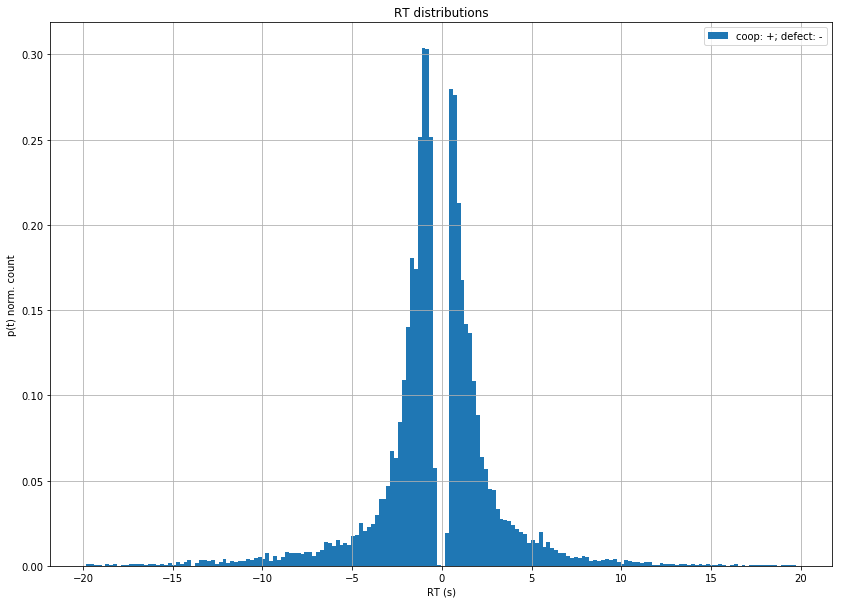

In [118]:
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions')
data.rt.hist(bins="auto",  ax=ax, density=True, histtype="stepfilled")
plt.legend(["coop: +; defect: -"])
plt.savefig('elias_rt.png')

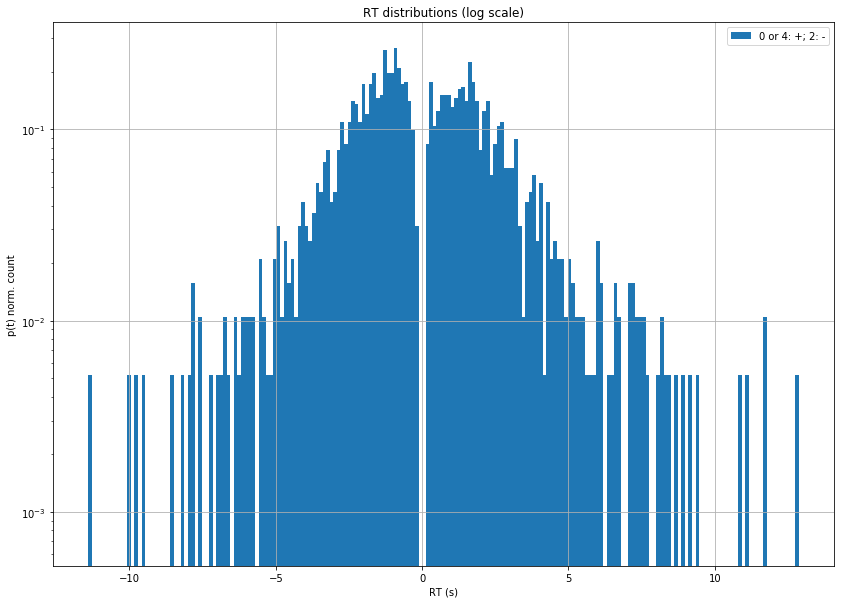

In [119]:
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions (log scale)')
dat.rt.hist(log=True,bins=200,  ax=ax, density=True, histtype="stepfilled")
plt.legend(["0 or 4: +; 2: -"])
plt.savefig('elias_rt_logscale.png')

C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 40.5 sec        mean        std        2.5q        25q        50q        75q  \
a    2.75388  0.0330449     2.68699    2.73169    2.75464    2.77601   
v -0.0463907  0.0191021  -0.0839269 -0.0594235 -0.0463881 -0.0333423   
t  0.0183986  0.0072949  0.00630057  0.0129188  0.0177397  0.0231204   

        97.5q       mc err  
a      2.8184  0.000793355  
v -0.00945597  0.000482066  
t   0.0346588  0.000188542  


C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
C:\Users\Esther Rodrigo\AppData\Local\conda\conda\envs\hddm-related\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


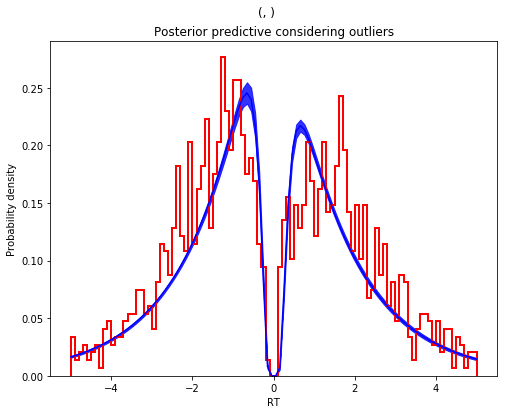

In [102]:
m_outlier = hddm.HDDM(dat, p_outlier=.05)
m_outlier.sample(2000, burn=20)
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive considering outliers')
plt.xlabel('RT')
plt.ylabel('Probability density')
plt.savefig("elias_rt_aprox.pdf")
statse=m_outlier.gen_stats()
print(statse)

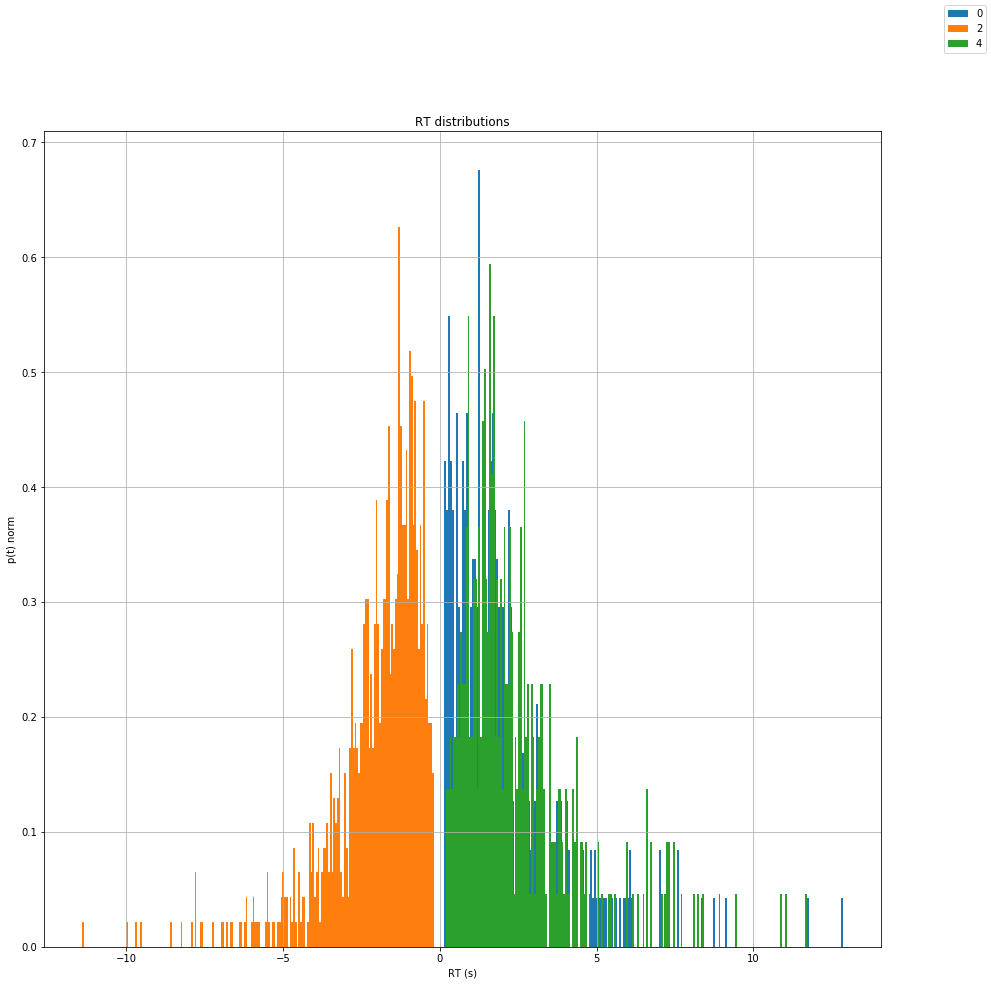

In [160]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm', title='RT distributions')
for i, subj_data in dat.groupby("actions"):
    subj_data.rt.hist(bins=200,  ax=ax, density=True)
fig.legend(["0","2","4"])

In [162]:
dat1=dat[dat["rounds"]==1]
dat2=dat[(dat["rounds"]==10)  & (dat["treatment"]==1)]
print(dat2)

     index  actions  age            degree  group  knows_game  knows_gt  \
8        8        0   26  Computer Science     21       False       0.0   
12      12        0   26           Biology     21       False       1.0   
25      25        2   20        Psychology     21       False       0.0   
31      31        2   23  Computer Science     21       False       1.0   
47      47        4   27       Engineering     21       False       0.0   
58      58        0   24       Engineering     21       False       0.0   
62      62        2   23  Computer Science     22        True       1.0   
74      74        4   39           Physics     22        True       0.0   
87      87        4   23           Economy     22       False       0.0   
93      93        2   22  Computer Science     22       False       0.0   
109    109        2   25           Economy     22        True       0.0   
117    117        0   24             Other     22       False       0.0   
125    125        4   29 

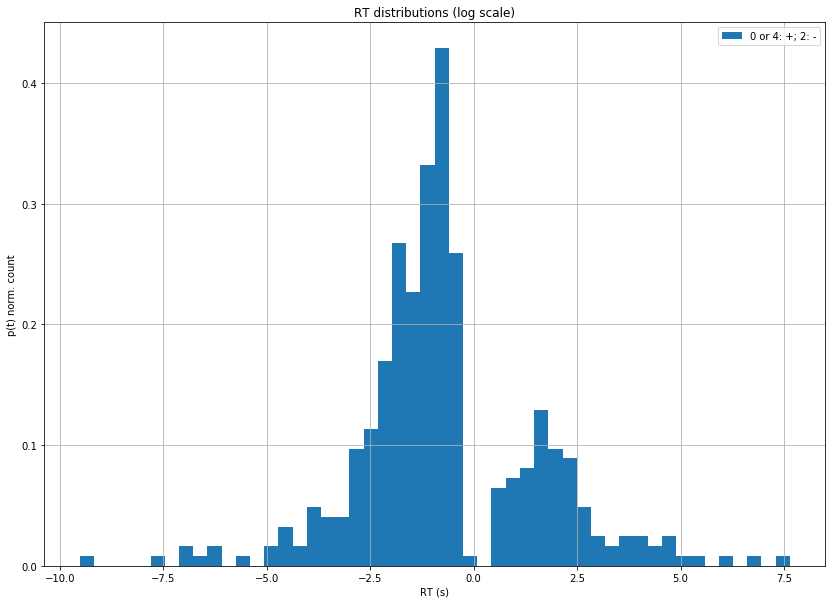

In [155]:
dat1=dat[dat.apply(lambda x: x.treatment==1 and x.rounds<6, axis=1)]
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions (log scale)')
dat1.rt.hist(bins=50,  ax=ax, density=True, histtype="stepfilled")
plt.legend(["0 or 4: +; 2: -"])
plt.savefig('elias_rt_logscale_round1.png')

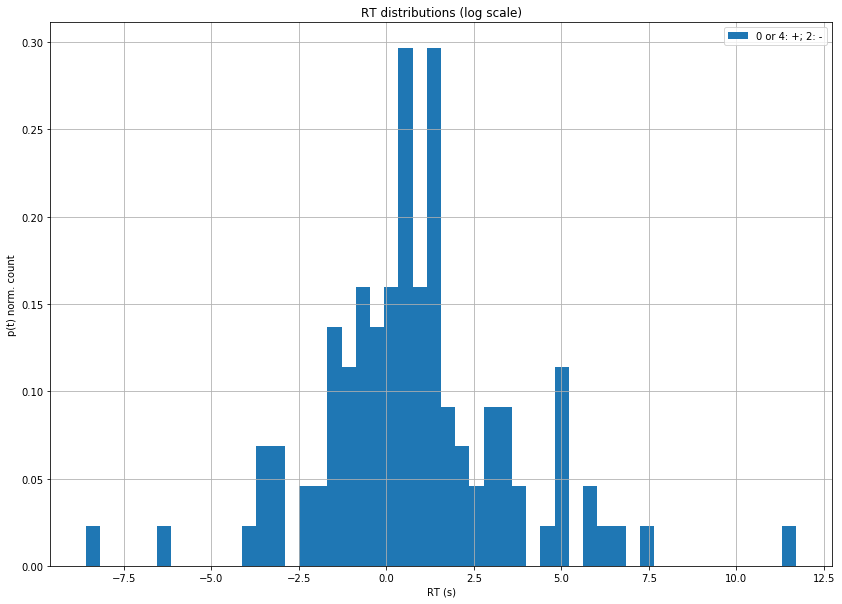

In [159]:
dat1=dat[dat.apply(lambda x: x.rounds==10, axis=1)]
fig = plt.figure(figsize=(14,10), )
ax = fig.add_subplot(111, xlabel='RT (s)', ylabel='p(t) norm. count', title='RT distributions (log scale)')
dat1.rt.hist(bins=50,  ax=ax, density=True, histtype="stepfilled")
plt.legend(["0 or 4: +; 2: -"])
plt.savefig('elias_rt_logscale_round10.png')